#  Tumor classification 
dataset 
#  [here](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)


# Import libreries

In [2]:
import tensorflow.keras.applications as apps

# List available models in the applications module
print(dir(apps))

['ConvNeXtBase', 'ConvNeXtLarge', 'ConvNeXtSmall', 'ConvNeXtTiny', 'ConvNeXtXLarge', 'DenseNet121', 'DenseNet169', 'DenseNet201', 'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7', 'EfficientNetV2B0', 'EfficientNetV2B1', 'EfficientNetV2B2', 'EfficientNetV2B3', 'EfficientNetV2L', 'EfficientNetV2M', 'EfficientNetV2S', 'InceptionResNetV2', 'InceptionV3', 'MobileNet', 'MobileNetV2', 'MobileNetV3Large', 'MobileNetV3Small', 'NASNetLarge', 'NASNetMobile', 'ResNet101', 'ResNet101V2', 'ResNet152', 'ResNet152V2', 'ResNet50', 'ResNet50V2', 'VGG16', 'VGG19', 'Xception', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'convnext', 'densenet', 'efficientnet', 'efficientnet_v2', 'imagenet_utils', 'inception_resnet_v2', 'inception_v3', 'mobilenet', 'mobilenet_v2', 'mobilenet_v3', 'nasnet', 'resnet', 'resnet50', 'resnet_v2', 'vgg16', 'vgg19', 

In [1]:
import tensorflow as tf
import warnings

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import os
print(os.getcwd())

/kaggle/working


# Set Up Paths and Parameters

In [2]:
# Paths to  dataset
train_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
test_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'

# Image size and batch size
img_size = 224  # MobileNet requires 224x224 images
batch_size = 32  #
num_classes = 4  # Normal, Glioma, Pituitary, Meningioma


# Data Augmentation and Preprocessing

In [3]:
# Import necessary libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Rescaling for validation/test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',  # For multi-class classification
    shuffle=True  # Shuffle data for better training
)

# Validation/Test data generator
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Calculate steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

# Debugging information
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")

# Ensure the generators work as intended
for data_batch, labels_batch in train_generator:
    print(f"Data batch shape: {data_batch.shape}")
    print(f"Labels batch shape: {labels_batch.shape}")
    break  # Check the first batch and stop


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Training samples: 5712
Validation samples: 1311
Data batch shape: (32, 224, 224, 3)
Labels batch shape: (32, 4)


# Load VGG-19 Base Model

In [ ]:
from tensorflow.keras.applications import VGG19

# Load VGG19 with pre-trained weights, without the top layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model layers so they are not trainable
base_model.trainable = False


# Build the Model

In [ ]:
# Load VGG19 with pre-trained weights, without the top layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model layers so they are not trainable
base_model.trainable = False

# Add custom layers on top of VGG19
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dense(512, activation='relu')(x)  # Another fully connected layer

# Output layer (4 classes: Notumor, Glioma, Pituitary, Meningioma)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model architecture
model.summary()


# Train the Model

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # Adjust the number of epochs
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=validation_generator.samples // batch_size
)


# Visualize Training Results (Accuracy & Loss)

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Save the model

In [ ]:

model.save('model/brain_tumor_classification_VGG19_mod.h5')


# Prediction validation and plotting confusion matrix with f1 score
These are key performance metrics in binary or multiclass classification tasks. They help evaluate how well a model performs in predicting the true class labels. Here's what each term means along with its formula:

1. Accuracy
Definition: Accuracy is the ratio of correctly predicted instances to the total instances. It tells us the overall correctness of the model but may not be ideal in the case of imbalanced datasets.

 
Where:

TP (True Positive): The model correctly predicted a positive class (e.g., "Tumor Detected").
TN (True Negative): The model correctly predicted a negative class (e.g., "No Tumor").
FP (False Positive): The model incorrectly predicted a positive class (false alarm).
FN (False Negative): The model incorrectly predicted a negative class (missed detection).
2. Precision
Definition: Precision (or Positive Predictive Value) is the ratio of correctly predicted positive instances to the total predicted positives. It indicates how reliable the model’s positive predictions are.



 
High precision means that most predicted positives are actual positives.
A model with high precision has fewer false positives.
3. Recall (Sensitivity or True Positive Rate)
Definition: Recall is the ratio of correctly predicted positive instances to all actual positives. It shows how well the model captures the positive class.


 
High recall means that the model is capturing most of the actual positives.
A model with high recall has fewer false negatives.
4. F1-Score (Harmonic Mean of Precision and Recall)
Definition: The F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall, especially useful when the dataset is imbalanced.



The F1-score ranges from 0 to 1, where 1 indicates perfect precision and recall.
It's a good metric to consider when there is an uneven class distribution, as it penalizes extreme values of precision or recall.

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score

In [ ]:
# Load the saved model
model = load_model('/kaggle/working/model/brain_tumor_classification_VGG19_mod.h5')

# Define the image size
img_size = 224  # Image size used for MobileNet (replace if different)

# Load and preprocess a test image
img_path = '/kaggle/input/brain-tumor-dataset/Brain_Tumor_Multiclass_Dataset/Validation/meningioma/M_101_VF_.jpg'  # Replace with the path to your test image
img = image.load_img(img_path, target_size=(img_size, img_size))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Make prediction
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)

# Class mapping (adjust to your class indices)
class_indices = {0: 'notumor', 1: 'Glioma', 2: 'Pituitary', 3: 'Meningioma'}
print(f"Predicted class: {class_indices[predicted_class[0]]}")


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming your test set is in 'Dataset/Testing' folder, set the path
test_dir = '/kaggle/input/brain-tumor-dataset/Brain_Tumor_Multiclass_Dataset/Validation'

# Image data generator for test images
test_datagen = ImageDataGenerator(rescale=1./255)

# Test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Generate predictions
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


In [ ]:
# Generate predictions (from the previous step)
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes


In [ ]:
# Calculate F1 score for each class
f1 = f1_score(y_true, y_pred, average=None)  # F1 score for each class
print(f"F1 Score for each class: {f1}")

# Calculate macro and weighted F1 score
f1_macro = f1_score(y_true, y_pred, average='macro')  # Macro average F1 score
f1_weighted = f1_score(y_true, y_pred, average='weighted')  # Weighted average F1 score

print(f"Macro F1 Score: {f1_macro}")
print(f"Weighted F1 Score: {f1_weighted}")


# Acccuracy,precision,recall and  F score 

# Testing with another dataset

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming your test set is in 'Dataset/Testing' folder, set the path
test_dir = '../btdata/testing'
img_size = 224
# Image data generator for test images
test_datagen = ImageDataGenerator(rescale=1./255)

# Test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Generate predictions
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


# modifying function to detect presence of tumor

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from tqdm import tqdm  # for progress bar

# Load the pre-trained multiclass model (change the path to your model file)
MODEL_PATH = '/kaggle/working/model/brain_tumor_classification_VGG19_mod.h5'
model = tf.keras.models.load_model(MODEL_PATH)

# Class labels (Change these based on your tumor classes)
class_labels = ['Glioma', 'Meningioma', 'Normal', 'Pituitary']

# Define a function to preprocess the image
def prepare_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Adjust to your model's input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize
    return img_array

# Function to predict binary output (tumor vs. no tumor)
def predict_binary(model, img_path):
    img = prepare_image(img_path)
    preds = model.predict(img)
    prediction = np.argmax(preds, axis=1)[0]
    tumor_type = class_labels[prediction]
    
    # Binary classification: 1 for tumor detected, 0 for no tumor
    return 1 if tumor_type != 'Normal' else 0

# Function to load images and true labels from a directory
def load_images_from_directory(directory, true_label, num_images=None):
    images = []
    labels = []
    for i, img_name in enumerate(tqdm(os.listdir(directory))):
        if num_images and i >= num_images:
            break
        img_path = os.path.join(directory, img_name)
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            images.append(img_path)
            labels.append(true_label)
    return images, labels

# Paths to directories containing test data (change these paths accordingly)
healthy_dir = '/kaggle/input/brain-tumor-dataset/Brain_Tumor_Multiclass_Dataset/Validation/normal'  # No tumor (Healthy)
tumor_dirs = ['/kaggle/input/brain-tumor-dataset/Brain_Tumor_Multiclass_Dataset/Validation/glioma', 
              '/kaggle/input/brain-tumor-dataset/Brain_Tumor_Multiclass_Dataset/Validation/meningioma', 
              '/kaggle/input/brain-tumor-dataset/Brain_Tumor_Multiclass_Dataset/Validation/pituitary']

# Load healthy test images
healthy_images, healthy_labels = load_images_from_directory(healthy_dir, 0)  # 0 = No tumor

# Load tumor test images from each folder and assign labels accordingly
tumor_images = []
tumor_labels = []
for i, tumor_dir in enumerate(tumor_dirs):
    images, labels = load_images_from_directory(tumor_dir, 1)  # 1 = Tumor detected
    tumor_images.extend(images)
    tumor_labels.extend(labels)

# Combine all test images and labels
all_images = healthy_images + tumor_images
true_labels = healthy_labels + tumor_labels

# Predict on test data
predictions = []
for img_path in tqdm(all_images):
    pred = predict_binary(model, img_path)
    predictions.append(pred)



In [ ]:
# plot a matrix

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=['No Tumor', 'Tumor Detected'], yticklabels=['No Tumor', 'Tumor Detected'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix: Tumor Detection')
plt.show()

# AlexNet

In [ ]:

# Define the input shape and number of classes
img_size = 224  # Image size (adjust as needed)
num_classes = 4  # Number of output classes (e.g., Notumor, Glioma, Pituitary, Meningioma)

# Build AlexNet
alexnet = Sequential([
    # 1st Convolutional Layer
    Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    # 2nd Convolutional Layer
    Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    # 3rd Convolutional Layer
    Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'),

    # 4th Convolutional Layer
    Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'),

    # 5th Convolutional Layer
    Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

    # Flatten and Fully Connected Layers
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),  # Dropout to reduce overfitting
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Output layer
])

# Compile the model
alexnet.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model architecture
alexnet.summary()

# Train AlexNet

In [ ]:
# Train the model
history = alexnet.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=20,  # Adjust the number of epochs as needed
    validation_data=validation_generator, 
    validation_steps=validation_steps,
)

# Visualize Training Results (Accuracy & Loss)

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Save Model

In [ ]:
alexnet.save('model/brain_tumor_classification_VGG19_mod.h5')

# Prediction validation and plotting confusion matrix with f1 score

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming your test set is in 'Dataset/Testing' folder, set the path
test_dir = '/kaggle/input/Brain_Tumor_Multiclass_Dataset/Validation'

# Image data generator for test images
test_datagen = ImageDataGenerator(rescale=1./255)

# Test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Generate predictions
Y_pred = alexnet.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


AlexNet is overfitting

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer

# Assuming your test set is in 'Dataset/Testing' folder, set the path
test_dir = '/kaggle/input/Brain_Tumor_Multiclass_Dataset/Validation'

# Image data generator for test images
test_datagen = ImageDataGenerator(rescale=1./255)

# Test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Generate predictions
Y_pred = alexnet.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Binarize the true labels
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(y_true)

# Calculate the ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

# Iterate over each class
for i in range(y_true_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(10, 8))

# Plot ROC curve for each class
for i in range(y_true_bin.shape[1]):
    plt.plot(fpr[i], tpr[i], color='b', lw=2, label=f'Class {i+1} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Add labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multiclass Classification')
plt.legend(loc='lower right')

# Show the plot
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
precision, recall, _ = precision_recall_curve(y_true_bin[:, 1], Y_pred[:, 1])
pr_auc = auc(recall, precision)

plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


# EfficientNet

In [4]:
from tensorflow.keras.applications import EfficientNetB0

# Load EfficientNetB0 with pre-trained weights, without the top layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model layers so they are not trainable
base_model.trainable = False



16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Compile model

In [7]:
# Add custom layers on top of EfficientNetB0
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dense(512, activation='relu')(x)  # Another fully connected layer

# Output layer (4 classes: Notumor, Glioma, Pituitary, Meningioma)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model architecture
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 5,888,167 (22.46 MB)

 Trainable params: 1,838,596 (7.01 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

# Train EfficientNet

In [8]:
warnings.filterwarnings('ignore')

In [9]:
# Train the model
history = model.fit(
    train_generator, 
    steps_per_epoch=steps_per_epoch, 
    epochs=20,  # Adjust the number of epochs as needed
    validation_data=validation_generator, 
    validation_steps=validation_steps,
)

Epoch 1/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 128s 576ms/step - accuracy: 0.2817 - loss: 1.3861 - val_accuracy: 0.3117 - val_loss: 1.3779
Epoch 2/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.2812 - loss: 1.3959 - val_accuracy: 0.1935 - val_loss: 1.4032
Epoch 3/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 67s 364ms/step - accuracy: 0.2881 - loss: 1.3838 - val_accuracy: 0.2336 - val_loss: 1.3843
Epoch 4/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step - accuracy: 0.4375 - loss: 1.3688 - val_accuracy: 0.0323 - val_loss: 1.4145
Epoch 5/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 67s 361ms/step - accuracy: 0.2788 - loss: 1.3844 - val_accuracy: 0.3086 - val_loss: 1.3799
Epoch 6/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 305us/step - accuracy: 0.2188 - loss: 1.3982 - val_accuracy: 0.3226 - val_loss: 1.3659
Epoch 7/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 67s 363ms/step - accuracy: 0.2858 - loss: 1.3818 - val_accuracy: 0.3078 - val_loss: 1.3794
Epoch 8/20
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step - accuracy: 0.1250 - loss: 1.420

# Visualize Training Results (Accuracy & Loss)

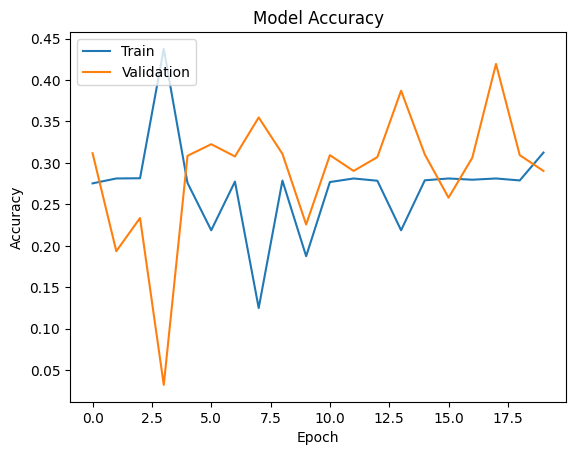

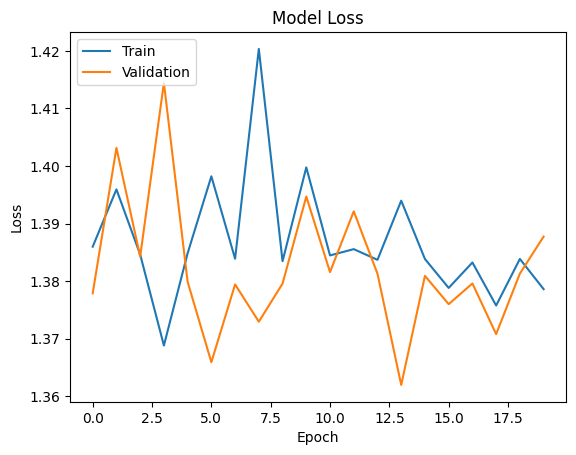

In [10]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
model.save('model/brain_tumor_classification_Efficient_mod.h5')

# Prediction validation and plotting confusion matrix with f1 score

In [11]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming your test set is in 'Dataset/Testing' folder, set the path
test_dir = '/kaggle/input/brain-tumor-dataset/Brain_Tumor_Multiclass_Dataset/Validation'

# Image data generator for test images
test_datagen = ImageDataGenerator(rescale=1./255)

# Test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Generate predictions
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes


Found 5720 images belonging to 4 classes.
179/179 ━━━━━━━━━━━━━━━━━━━━ 34s 162ms/step


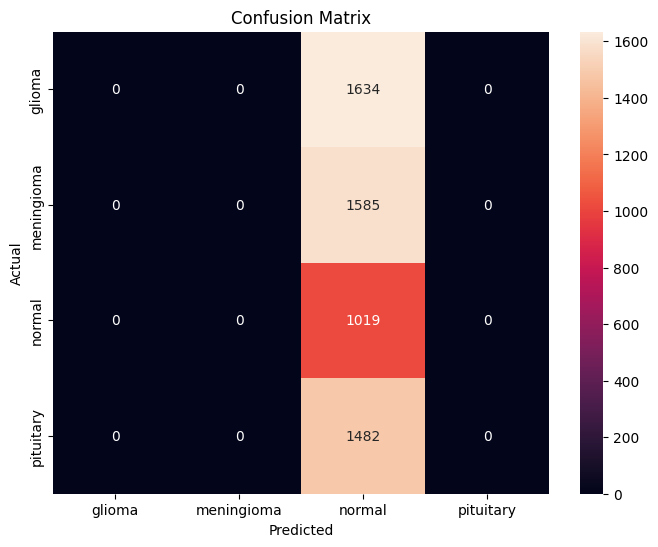

Classification Report:
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00      1634
  meningioma       0.00      0.00      0.00      1585
      normal       0.18      1.00      0.30      1019
   pituitary       0.00      0.00      0.00      1482

    accuracy                           0.18      5720
   macro avg       0.04      0.25      0.08      5720
weighted avg       0.03      0.18      0.05      5720



In [14]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="rocket", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import os

# Define dataset paths
data_dir = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset"

# Ensure only class folders are present
print("Folders in dataset:", os.listdir(data_dir))

# Define data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Splitting during training
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

# Print detected class indices
print("Classes found:", train_generator.class_indices)

# Load EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model layers

# Build model
global_pool = GlobalAveragePooling2D()(base_model.output)
dropout = Dropout(0.5)(global_pool)
out = Dense(1, activation='sigmoid')(dropout)

model = Model(inputs=base_model.input, outputs=out)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit(train_generator, validation_data=validation_generator, epochs=10)

# Save model
model.save("brain_tumor_detector.h5")

Folders in dataset: ['no', 'yes']
Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Classes found: {'no': 0, 'yes': 1}
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.5814 - loss: 0.6913 - val_accuracy: 0.6200 - val_loss: 0.6784
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.6078 - loss: 0.6804 - val_accuracy: 0.6200 - val_loss: 0.6691
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.6043 - loss: 0.6754 - val_accuracy: 0.6200 - val_loss: 0.6656
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.6185 - loss: 0.6642 - val_accuracy: 0.6200 - val_loss: 0.6644
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.6209 - loss: 0.6643 - val_accuracy: 0.6200 - val_loss: 0.6644
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.6011 - loss: 0.6762 - val_accuracy: 0.6200 - val_loss: 0.6644
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.6204 - loss: 0.6579 - val_accura

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step


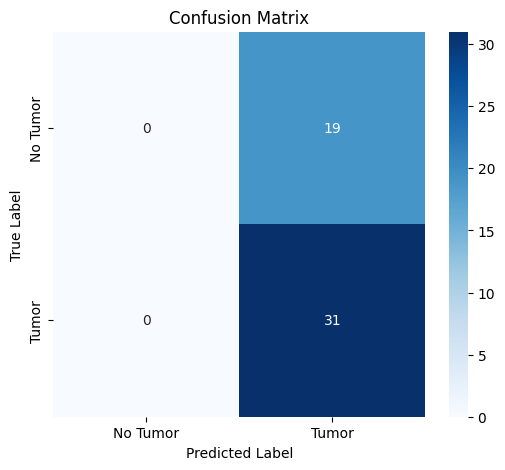

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate predictions
y_true = validation_generator.classes
y_pred = model.predict(validation_generator).ravel()
y_pred_labels = (y_pred > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Tumor", "Tumor"], yticklabels=["No Tumor", "Tumor"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


##### from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Generate predictions
y_true = validation_generator.classes
y_pred = model.predict(validation_generator).ravel()
y_pred_labels = (y_pred > 0.5).astype(int)

# Compute classification metrics
accuracy = accuracy_score(y_true, y_pred_labels)
precision = precision_score(y_true, y_pred_labels)
recall = recall_score(y_true, y_pred_labels)
f1 = f1_score(y_true, y_pred_labels)
roc_auc = roc_auc_score(y_true, y_pred)

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

# Detailed classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred_labels, target_names=["No Tumor", "Tumor"]))


In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Take a small batch of images as background data
x_train_batch, _ = next(train_generator)
background = x_train_batch[:50]  # Use 50 images for SHAP background

# KernelExplainer requires a wrapper function for the model
def model_fn(x):
    return model.predict(x.reshape((-1, 224, 224, 3)), verbose=0)

# Initialize SHAP KernelExplainer
explainer = shap.KernelExplainer(model_fn, background[:10].reshape(10, -1))  # Use smaller background to speed up

# Select 5 sample images from the validation set
x_batch, y_batch = next(validation_generator)
sample_images = x_batch[:5]

# Compute SHAP values
shap_values = explainer.shap_values(sample_images.reshape(5, -1))  # Flatten input for SHAP

# Reshape SHAP values back to original image dimensions
shap_values = np.array(shap_values).reshape(-1, 224, 224, 3)

# Plot SHAP explanations
for i in range(len(sample_images)):
    plt.figure(figsize=(8, 4))
    
    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(sample_images[i])
    plt.axis("off")
    plt.title("Original Image")
    
    # SHAP Explanation (Use absolute values to highlight important regions)
    plt.subplot(1, 2, 2)
    plt.imshow(np.abs(shap_values[i]).mean(axis=-1), cmap="inferno")  # Heatmap
    plt.axis("off")
    plt.title("SHAP Learning Region")
    
    plt.show()


  0%|          | 0/5 [00:00<?, ?it/s]

# Train mobilenet_v3

In [ ]:
# Define dataset paths
train_dir = "/kaggle/input/Brain_Tumor_Multiclass_Dataset/Train"
val_dir = "/kaggle/input/Brain_Tumor_Multiclass_Dataset/Validation/"

# Image properties
IMG_SIZE = (224, 224)  # EfficientNetB0 input size
BATCH_SIZE = 32  # Adjust based on available memory
AUTOTUNE = tf.data.AUTOTUNE  # Optimizes data loading


In [ ]:
# Load images using `image_dataset_from_directory`
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=False  # No need to shuffle validation data
)

# Optimize dataset loading
def configure_for_performance(ds):
    ds = ds.prefetch(buffer_size=AUTOTUNE)  # Preloads batches into memory for smooth GPU utilization
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)


In [ ]:
from tensorflow.keras.applications import MobileNetV3Large  # or MobileNetV3Small
from tensorflow.keras import layers, models

# Define image size
IMG_SIZE = 224  # MobileNetV3 standard input size

# Load MobileNetV3 with pre-trained weights, without top layers
base_model = MobileNetV3Large(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), alpha=1.0)

# Freeze the base model layers
base_model.trainable = False

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(4, activation="softmax")  # Assuming 4 output classes
])

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Summary
model.summary()


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # Adjust the number of epochs
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=validation_generator.samples // batch_size
)


# Visualize Training Results (Accuracy & Loss)

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# save model

In [ ]:
model.save('/kaggle/working/mobilenetv3_model.h5', save_format='h5', include_optimizer=True)


In [ ]:
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras import layers, models

IMG_SIZE = 224  # Ensure this matches your training setup

# Step 1: Define the same MobileNetV3Large architecture
base_model = MobileNetV3Large(weights=None, include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), alpha=1.0)

# Keep layers frozen as in training
base_model.trainable = False

# Step 2: Rebuild the Sequential model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(4, activation="softmax")  # Must match original output classes
])

# Step 3: Load the saved weights
model.load_weights('/kaggle/working/mobilenetv3_model.h5')

# Step 4: Compile again (needed for evaluation & inference)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Step 5: Verify everything
model.summary()


In [ ]:
import h5py

with h5py.File('/kaggle/working/final_model.h5', 'r') as f:
    print(list(f.keys()))  # Shows what’s inside (weights, model config, etc.)


In [ ]:
!rm /kaggle/working/model/brain_tumor_classification_MobileNet_V3_mod.h5


 # Prediction validation and plotting confusion matrix with f1 score

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score
from tensorflow.keras.models import load_model

In [ ]:


model_path = "/kaggle/input/mobilenetv_3/keras/default/1/brain_tumor_classification_mobilenet_mod.h5"
model = load_model(model_path)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming your test set is in 'Dataset/Testing' folder, set the path
test_dir = '/kaggle/input/brain-tumor-dataset/Brain_Tumor_Multiclass_Dataset/Validation'

# Image data generator for test images
test_datagen = ImageDataGenerator(rescale=1./255)

# Test data generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Generate predictions
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


# modifying function to detect presence of tumor

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from tqdm import tqdm  # for progress bar

# Load the pre-trained multiclass model (change the path to your model file)
MODEL_PATH = '/kaggle/input/mobilenetv_3/keras/default/1/brain_tumor_classification_mobilenet_mod.h5'
model = tf.keras.models.load_model(MODEL_PATH)

# Class labels (Change these based on your tumor classes)
class_labels = ['Glioma', 'Meningioma', 'Normal', 'Pituitary']

# Define a function to preprocess the image
def prepare_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Adjust to your model's input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize
    return img_array

# Function to predict binary output (tumor vs. no tumor)
def predict_binary(model, img_path):
    img = prepare_image(img_path)
    preds = model.predict(img)
    prediction = np.argmax(preds, axis=1)[0]
    tumor_type = class_labels[prediction]
    
    # Binary classification: 1 for tumor detected, 0 for no tumor
    return 1 if tumor_type != 'Normal' else 0

# Function to load images and true labels from a directory
def load_images_from_directory(directory, true_label, num_images=None):
    images = []
    labels = []
    for i, img_name in enumerate(tqdm(os.listdir(directory))):
        if num_images and i >= num_images:
            break
        img_path = os.path.join(directory, img_name)
        if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            images.append(img_path)
            labels.append(true_label)
    return images, labels

# Paths to directories containing test data (change these paths accordingly)
healthy_dir = '/kaggle/input/brain-tumor-dataset/Brain_Tumor_Multiclass_Dataset/Validation/normal'  # No tumor (Healthy)
tumor_dirs = ['/kaggle/input/brain-tumor-dataset/Brain_Tumor_Multiclass_Dataset/Validation/glioma', 
              '/kaggle/input/brain-tumor-dataset/Brain_Tumor_Multiclass_Dataset/Validation/meningioma', 
              '/kaggle/input/brain-tumor-dataset/Brain_Tumor_Multiclass_Dataset/Validation/pituitary']

# Load healthy test images
healthy_images, healthy_labels = load_images_from_directory(healthy_dir, 0)  # 0 = No tumor

# Load tumor test images from each folder and assign labels accordingly
tumor_images = []
tumor_labels = []
for i, tumor_dir in enumerate(tumor_dirs):
    images, labels = load_images_from_directory(tumor_dir, 1)  # 1 = Tumor detected
    tumor_images.extend(images)
    tumor_labels.extend(labels)

# Combine all test images and labels
all_images = healthy_images + tumor_images
true_labels = healthy_labels + tumor_labels

# Predict on test data
predictions = []
for img_path in tqdm(all_images):
    pred = predict_binary(model, img_path)
    predictions.append(pred)



In [ ]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Greens', xticklabels=['No Tumor', 'Tumor Detected'], yticklabels=['No Tumor', 'Tumor Detected'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix: Tumor Detection')
plt.show()